In [1]:
import pandas as pd
import numpy as np
PoliceIncident=pd.read_csv("datasets/d1.csv",usecols=[1,4])
# PoliceIncident=pd.read_csv("datasets/d2.csv",usecols=[1,4])
# PoliceIncident=pd.read_csv("datasets/d3.csv",usecols=[1,4])

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [3]:
PoliceIncident.to_csv('datasets/between.csv',columns=['Date_Occured','Type'],index=False,sep=',')

In [4]:
Police = pd.read_csv('datasets/between.csv', index_col=0, parse_dates=[0])
Police = Police['2016':'2018']
#converted = PoliceIncident.asfreq('45Min', method='pad')
Police = Police.resample('D').count()

In [9]:
# Create a training sample and testing sample before analyzing the series
n_sample = Police.shape[0]
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = Police.iloc[:n_train]['Type']
ts_test = Police.iloc[n_train:]['Type']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

NameError: name 'Police' is not defined

In [6]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

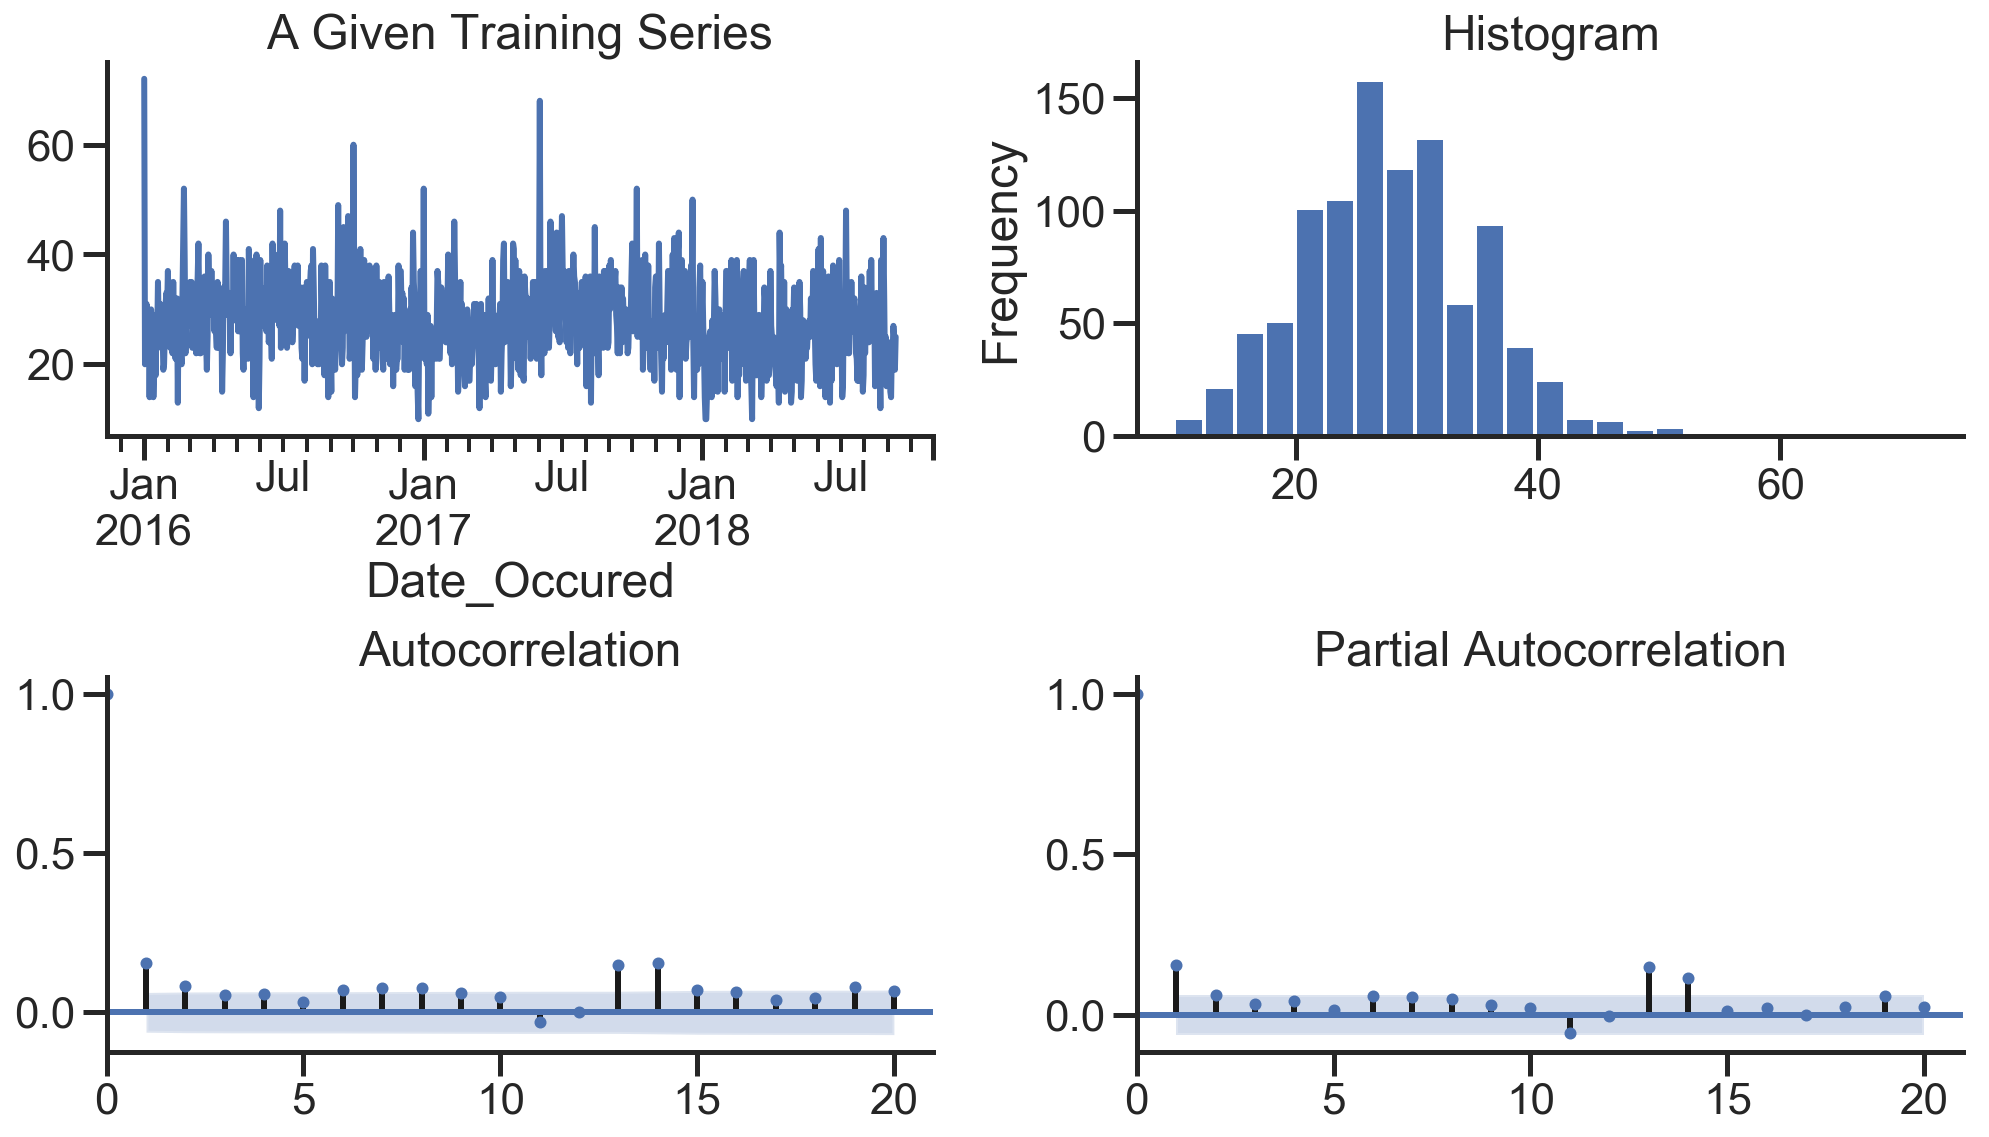

In [7]:
tsplot(ts_train, title='A Given Training Series', lags=20);

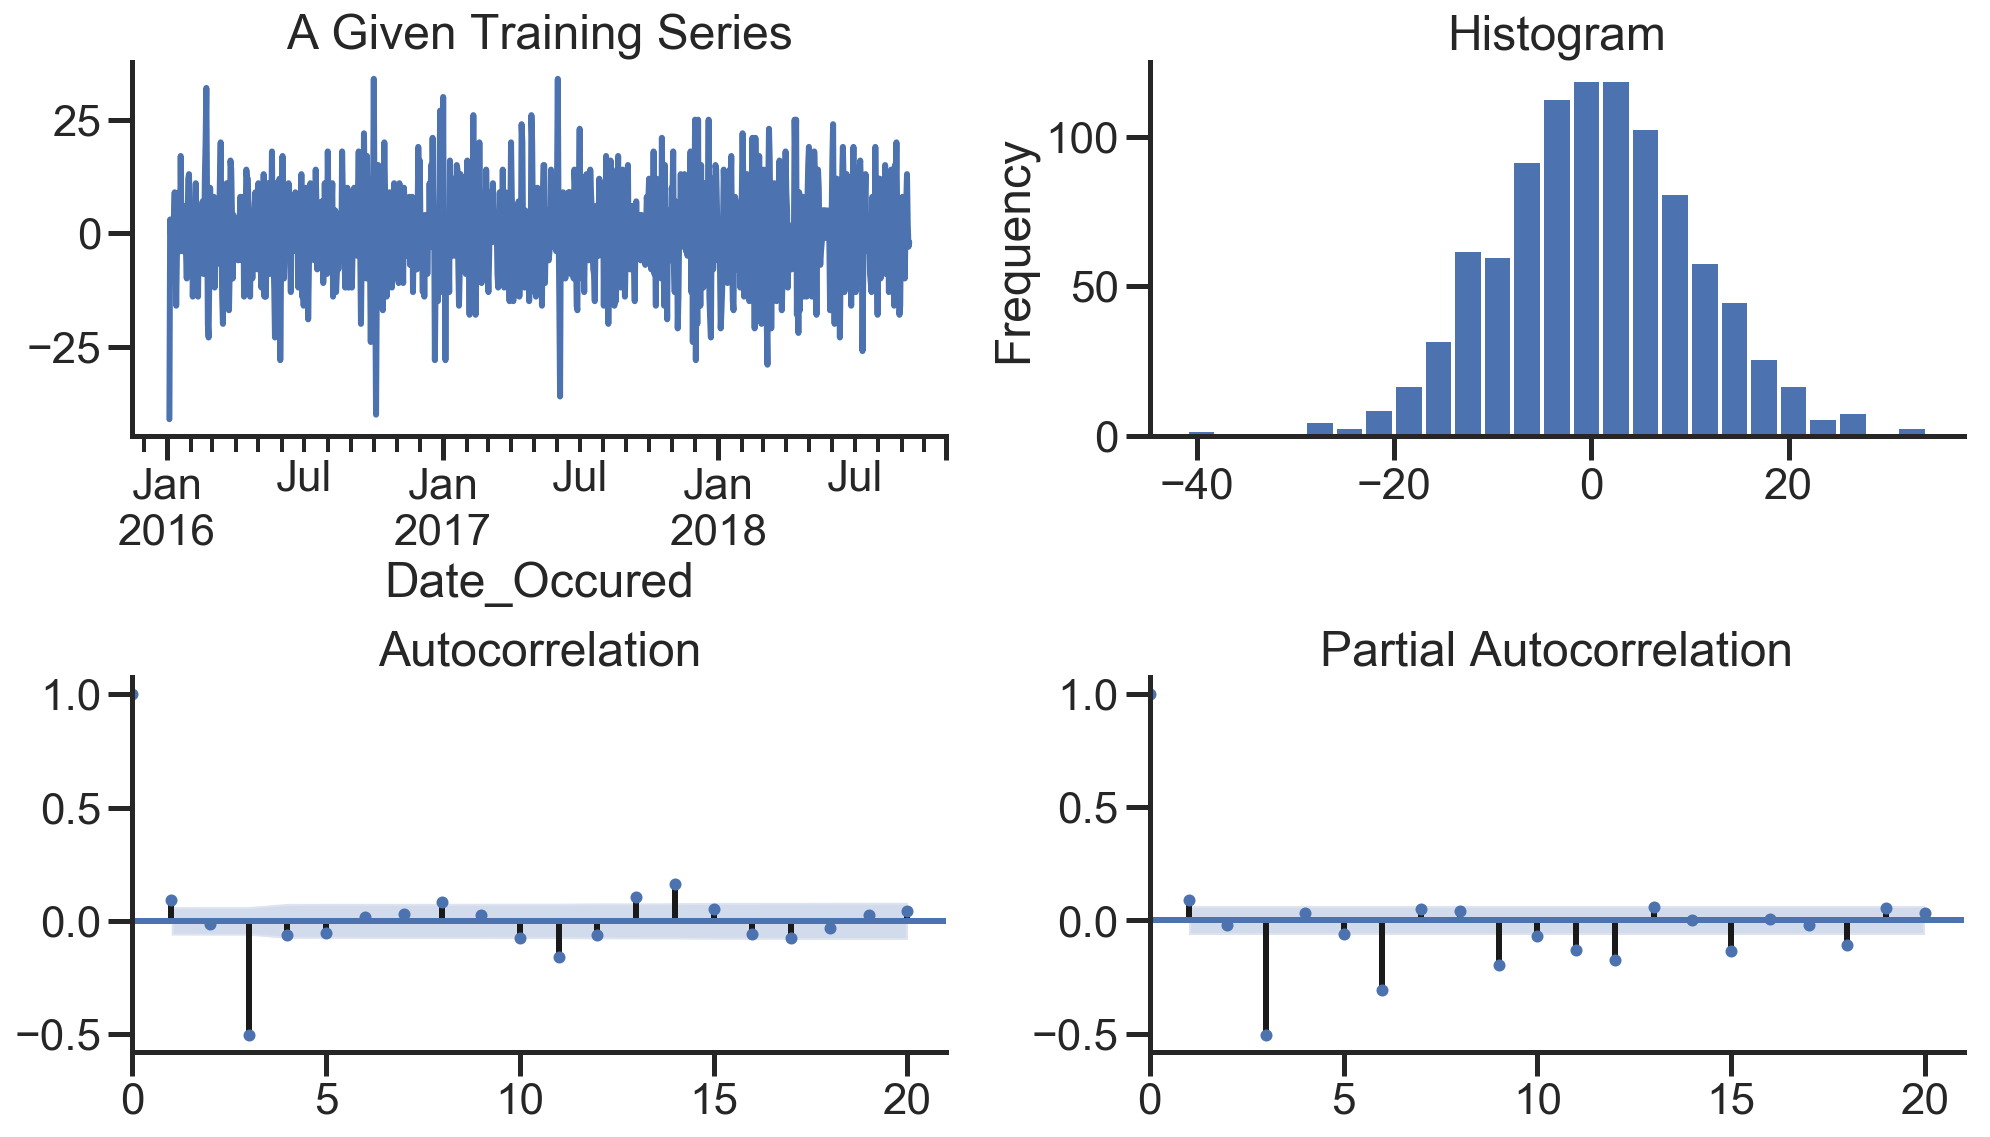

In [10]:
ts_train_diff=ts_train.diff(3)
ts_train_diff.dropna(inplace=True)
tsplot(ts_train_diff, title='A Given Training Series', lags=20);

In [16]:
# Model Estimation

# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(3,2,2))
model_results = arima200.fit()
model_results.summary()

C:\Users\chang\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Type   No. Observations:                  985
Model:               SARIMAX(3, 2, 2)   Log Likelihood               -3362.847
Date:                Sun, 02 Dec 2018   AIC                           6737.694
Time:                        23:32:42   BIC                           6767.037
Sample:                    01-01-2016   HQIC                          6748.856
                         - 09-11-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1016      0.034      3.013      0.003       0.036       0.168
ar.L2          0.0100      0.032      0.317      0.751      -0.052       0.072
ar.L3         -0.0135      0.035     -0.390      0.697      -0.081       0.054
ma.L1         -1.9696      0.013   -157.186      0.000      -1.994      -1.945
ma.L2          0.9696      0.012     79.049      0.000       0.946       0.994
sigma2        53.7932      2.134     25.212      0.000      49.611      57.975
===================================================================================
Ljung-Box (Q):                       64.34   Jarque-Bera (JB):                90.74
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.52
Prob(H) (two-sided):                  0.68   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

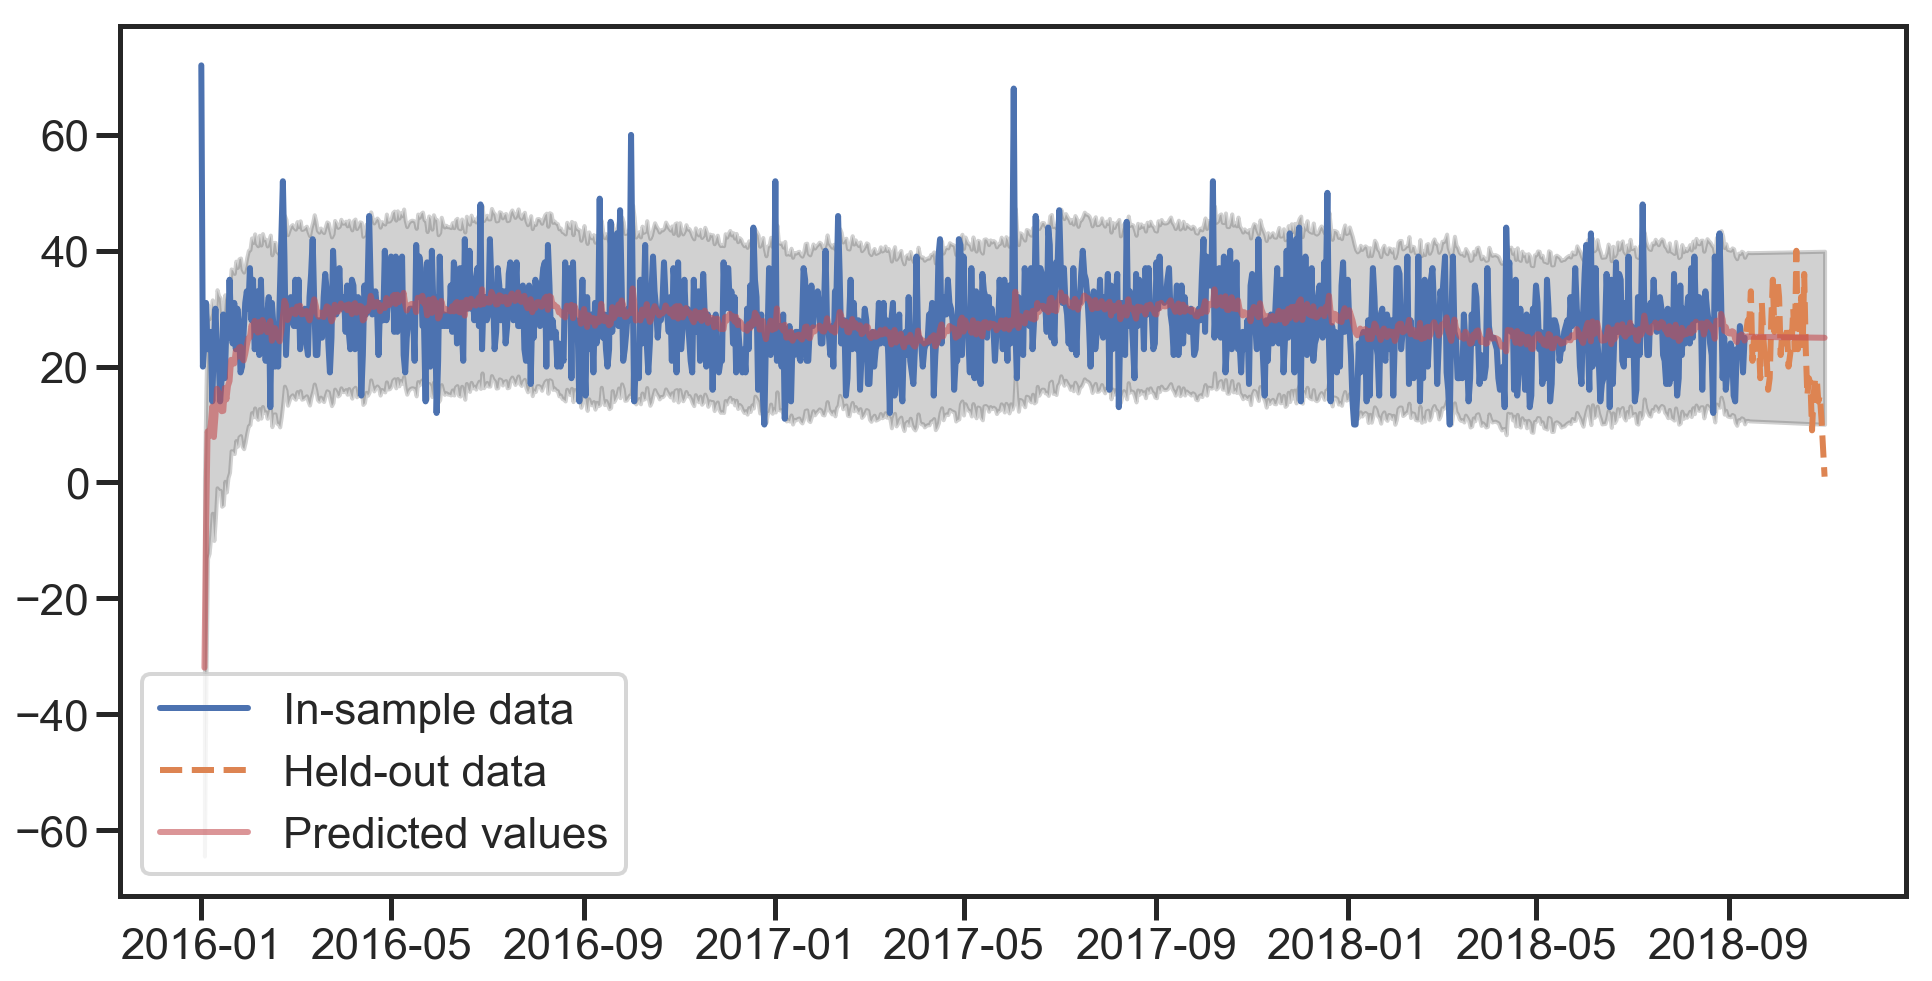

In [17]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [5]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))


In [7]:
rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)


NameError: name 'ts_train' is not defined

In [8]:
rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print(rmse)

NameError: name 'ts_test' is not defined